In [1]:
from datetime import datetime
from pathlib import Path
import os

import click
import torch
import wandb
from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers import WandbLogger
import logging
import lightning as L
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from transformers import EsmForMaskedLM, AutoTokenizer, EsmModel
from peft import get_peft_model, LoraConfig, TaskType, set_peft_model_state_dict, get_peft_model_state_dict


from egfr_binder_rd2.datamodule import SequenceDataModule
from egfr_binder_rd2.bt import BTRegressionModule, PartialEnsembleModule
from egfr_binder_rd2.binding_dataset import get_dataset


%load_ext autoreload
%autoreload 2

torch.set_float32_matmul_precision('medium')

seed = 42
debug = True


/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def setup_logging(debug: bool):
    level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(
        level=level,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    logger = logging.getLogger(__name__)
    logger.info("Logging setup complete.")
    return logger

In [10]:
df = get_dataset()
yvar = 'i_ptm'
xvar = 'binder_sequence'

In [11]:
label: str
# model_name: str = "facebook/esm2_t33_650M_UR50D"
model_name: str = "facebook/esm2_t6_8M_UR50D"
lr: float = 5e-4
peft_r: int = 8
peft_alpha: int = 16
max_length: int = 512

In [12]:

# Create and setup the DataModule
data_module = SequenceDataModule(
    df, 
    tokenizer_name="facebook/esm2_t33_650M_UR50D",
    xvar=xvar,
    yvar=yvar,  # You can change this to any other column name in your DataFrame
    batch_size=32,
    max_length=512,
    transform_type='standardize',
    make_negative=True,
)
data_module.setup()



/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 92/92 [00:00<00:00, 7384.20 examples/s]


In [13]:
# Initialize model
model = PartialEnsembleModule(
    label=yvar,
    num_heads=10,  # Number of ensemble heads
    model_name=model_name,
    lr=lr,
    peft_r=peft_r,
    peft_alpha=peft_alpha,
    max_length=max_length,
    dropout=0.15
)

# Initialize trainer
trainer = Trainer(
    max_epochs=10,
    accelerator='auto',
    devices=1,
    callbacks=[
        EarlyStopping(
            monitor='val_spearman',
            mode='max',
            patience=10,
            min_delta=0.001
        )
    ],
    logger=WandbLogger(project='egfr_binder_rd2_pe_scratch'),
    precision='32-true',
    log_every_n_steps=10,
    enable_checkpointing=False,
    val_check_interval=0.25,
)

# Train
trainer.fit(
    model=model,
    datamodule=data_module
)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/naka/code/egfr_binder_rd2/.venv/lib/python3.11 ...
GPU available: True (cuda), used: True
TPU availa

Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  5.78it/s, v_num=9653]       

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  5.77it/s, v_num=9653]


In [14]:
model = model.eval()

In [15]:
# Get predictions for all splits
predictions = {
    'train': trainer.predict(model, dataloaders=data_module.train_dataloader(shuffle=False)),
    'val': trainer.predict(model, dataloaders=data_module.val_dataloader()),
    'test': trainer.predict(model, dataloaders=data_module.test_dataloader())
}

# Combine predictions
results = {
    'sequence': [],
    'prediction': [],  # ensemble mean
    'uncertainty': [], # ensemble std
    'target': [],
    'split': [],  # Track which split each prediction came from
}

# Add columns for each head
num_heads = model.hparams.num_heads
for i in range(num_heads):
    results[f'head_{i}'] = []

# Process predictions from each split
for split_name, split_predictions in predictions.items():
    for batch in split_predictions:
        sequences = batch['sequence']
        results['sequence'].extend(sequences)
        results['split'].extend([split_name] * len(sequences))
        
        # Handle ensemble predictions and uncertainties
        pred = batch['predictions'].cpu().numpy()
        unc = batch['uncertainties'].cpu().numpy()
        target = batch['target'].cpu().numpy()
        if pred.ndim > 1:
            pred = pred.squeeze()
        if unc.ndim > 1:
            unc = unc.squeeze()
        if target.ndim > 1:
            target = target.squeeze()
        results['prediction'].extend(pred.reshape(-1))
        results['uncertainty'].extend(unc.reshape(-1))
        results['target'].extend(target.reshape(-1))

        # Handle individual head predictions
        head_preds = batch['head_predictions'].cpu().numpy()
        if head_preds.ndim > 1:
            head_preds = head_preds.squeeze()
        if head_preds.ndim == 1:  # Single sample
            head_preds = head_preds.reshape(1, -1)
        
        # Add each head's predictions
        for i in range(num_heads):
            results[f'head_{i}'].extend(head_preds[:, i])

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Now you can analyze results by split
print("\nResults by split:")
for split in ['train', 'val', 'test']:
    split_df = results_df[results_df['split'] == split]
    correlation = spearmanr(split_df['prediction'], split_df['target']).correlation
    print(f"{split} split correlation: {correlation:.3f}")

Map: 100%|██████████| 92/92 [00:00<00:00, 7873.25 examples/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 23/23 [00:01<00:00, 21.07it/s]


Map: 100%|██████████| 92/92 [00:00<00:00, 7926.30 examples/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 21.41it/s] 


Map: 100%|██████████| 92/92 [00:00<00:00, 8230.44 examples/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 20.97it/s] 

Results by split:
train split correlation: 0.955
val split correlation: 0.910
test split correlation: 0.859


<Axes: xlabel='target', ylabel='value'>

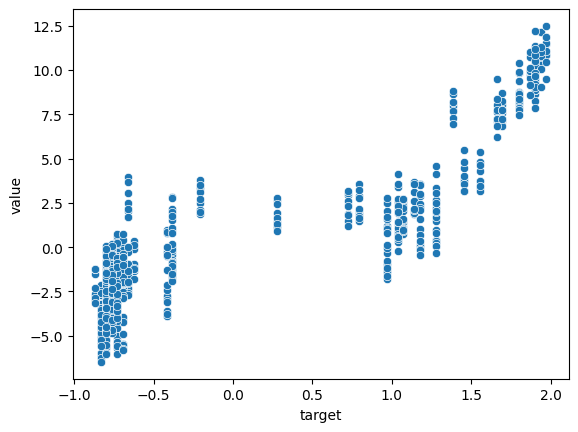

In [16]:
melted = results_df.melt(id_vars=['sequence', 'prediction', 'target', 'uncertainty', 'split'])
sns.scatterplot(melted.query('split == "test"'), x='target', y='value')

In [17]:
model.save_model("test.pt")

Model saved to: test.pt
Adapter state dict keys: ['base_model.model.encoder.layer.0.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.query.lora_B.weight', 'base_model.model.encoder.layer.0.attention.self.key.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.key.lora_B.weight', 'base_model.model.encoder.layer.0.attention.self.value.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.value.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.query.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.key.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.key.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.value.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.value.lora_B.weight', 'base_model.model.encoder.layer.2.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.2.a

/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [46]:
df['i_ptm']

seq_hash
5b353a    0.92
5b353a    0.91
5b353a    0.91
5b353a    0.90
5b353a    0.90
          ... 
01e6f1    0.88
eb14f3    0.89
bf226b    0.90
6b9521    0.90
229872    0.92
Name: i_ptm, Length: 912, dtype: float64

In [18]:
loaded_model = PartialEnsembleModule.load_model("test.pt")
loaded_model = loaded_model.eval()

/home/naka/code/egfr_binder_rd2/src/egfr_binder_rd2/bt.py:527: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_dict = torch.load(load_path)
Some weights of EsmModel were

Model loaded from: test.pt
Loaded adapter state dict keys: ['base_model.model.encoder.layer.0.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.query.lora_B.weight', 'base_model.model.encoder.layer.0.attention.self.key.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.key.lora_B.weight', 'base_model.model.encoder.layer.0.attention.self.value.lora_A.weight', 'base_model.model.encoder.layer.0.attention.self.value.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.query.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.query.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.key.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.key.lora_B.weight', 'base_model.model.encoder.layer.1.attention.self.value.lora_A.weight', 'base_model.model.encoder.layer.1.attention.self.value.lora_B.weight', 'base_model.model.encoder.layer.2.attention.self.query.lora_A.weight', 'base_model.model.encoder

/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [42]:
loaded_model.esm_model.base_model.model.embeddings

EsmEmbeddings(
  (word_embeddings): Embedding(33, 320, padding_idx=1)
  (dropout): Dropout(p=0.0, inplace=False)
  (position_embeddings): Embedding(1026, 320, padding_idx=1)
)

In [43]:
from egfr_binder_rd2.esm_regression_expert import EsmRegressionExpert

expert = EsmRegressionExpert(
    temperature=1.0,
    model=loaded_model,
    tokenizer=loaded_model.tokenizer,
)

In [19]:
batch = next(iter(data_module.test_dataloader()))

In [20]:
model = model.eval()

In [21]:
out = model.esm_model(batch['input_ids'], batch['attention_mask'])
out.pooler_output

tensor([[ 1.7851e-02, -1.4054e-01, -8.2440e-02,  ..., -1.7021e-01,
          1.3623e-01, -1.0688e-01],
        [ 1.1235e-02, -1.8316e-01, -6.7521e-02,  ..., -1.8192e-01,
          1.7823e-01, -1.3302e-01],
        [ 6.9933e-02, -5.9463e-02, -1.6813e-01,  ..., -2.4519e-01,
          1.3590e-01, -1.5412e-01],
        ...,
        [ 3.3352e-05, -1.6596e-01, -2.1874e-01,  ..., -1.2343e-02,
          2.3549e-01, -5.2100e-02],
        [ 5.4139e-02, -2.2205e-01, -1.0511e-01,  ..., -2.1645e-01,
          1.7424e-01, -1.9035e-01],
        [ 9.5082e-02, -1.4146e-01, -1.4028e-01,  ..., -7.0901e-02,
          1.8936e-01, -4.5907e-02]], grad_fn=<TanhBackward0>)

In [22]:
out = loaded_model.esm_model(batch['input_ids'], batch['attention_mask'])
out.pooler_output

tensor([[ 1.7851e-02, -1.4054e-01, -8.2440e-02,  ..., -1.7021e-01,
          1.3623e-01, -1.0688e-01],
        [ 1.1235e-02, -1.8316e-01, -6.7521e-02,  ..., -1.8192e-01,
          1.7823e-01, -1.3302e-01],
        [ 6.9933e-02, -5.9463e-02, -1.6813e-01,  ..., -2.4519e-01,
          1.3590e-01, -1.5412e-01],
        ...,
        [ 3.3352e-05, -1.6596e-01, -2.1874e-01,  ..., -1.2343e-02,
          2.3549e-01, -5.2100e-02],
        [ 5.4139e-02, -2.2205e-01, -1.0511e-01,  ..., -2.1645e-01,
          1.7424e-01, -1.9035e-01],
        [ 9.5082e-02, -1.4146e-01, -1.4028e-01,  ..., -7.0901e-02,
          1.8936e-01, -4.5907e-02]], grad_fn=<TanhBackward0>)

In [29]:
loaded_model.esm_model.base_model

LoraModel(
  (model): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): lora.Linear(
                (base_layer): Linear(in_features=320, out_features=320, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=320, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=320, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
 

In [23]:
# Get predictions for all splits
predictions = {
    'train': trainer.predict(loaded_model, dataloaders=data_module.train_dataloader(shuffle=False)),
    'val': trainer.predict(loaded_model, dataloaders=data_module.val_dataloader()),
    'test': trainer.predict(loaded_model, dataloaders=data_module.test_dataloader())
}

# Combine predictions
results = {
    'sequence': [],
    'prediction': [],  # ensemble mean
    'uncertainty': [], # ensemble std
    'target': [],
    'split': [],  # Track which split each prediction came from
}

# Add columns for each head
num_heads = model.hparams.num_heads
for i in range(num_heads):
    results[f'head_{i}'] = []

# Process predictions from each split
for split_name, split_predictions in predictions.items():
    for batch in split_predictions:
        sequences = batch['sequence']
        results['sequence'].extend(sequences)
        results['split'].extend([split_name] * len(sequences))
        
        # Handle ensemble predictions and uncertainties
        pred = batch['predictions'].cpu().numpy()
        unc = batch['uncertainties'].cpu().numpy()
        target = batch['target'].cpu().numpy()
        if pred.ndim > 1:
            pred = pred.squeeze()
        if unc.ndim > 1:
            unc = unc.squeeze()
        if target.ndim > 1:
            target = target.squeeze()
        results['prediction'].extend(pred.reshape(-1))
        results['uncertainty'].extend(unc.reshape(-1))
        results['target'].extend(target.reshape(-1))

        # Handle individual head predictions
        head_preds = batch['head_predictions'].cpu().numpy()
        if head_preds.ndim > 1:
            head_preds = head_preds.squeeze()
        if head_preds.ndim == 1:  # Single sample
            head_preds = head_preds.reshape(1, -1)
        
        # Add each head's predictions
        for i in range(num_heads):
            results[f'head_{i}'].extend(head_preds[:, i])

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Now you can analyze results by split
print("\nResults by split:")
for split in ['train', 'val', 'test']:
    split_df = results_df[results_df['split'] == split]
    correlation = spearmanr(split_df['prediction'], split_df['target']).correlation
    print(f"{split} split correlation: {correlation:.3f}")

/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/naka/code/egfr_binder_rd2/.venv/lib/python3.11 ...
Map: 100%|██████████| 92/92 [00:00<00:00, 7888.87 examples/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 23/23 [00:01<00:00, 21.03it/s]


Map: 100%|██████████| 92/92 [00:00<00:00, 8048.14 examples/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 21.59it/s] 


Map: 100%|██████████| 92/92 [00:00<00:00, 7826.30 examples/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 21.11it/s] 

Results by split:
train split correlation: 0.955
val split correlation: 0.910
test split correlation: 0.859


<Axes: xlabel='target', ylabel='value'>

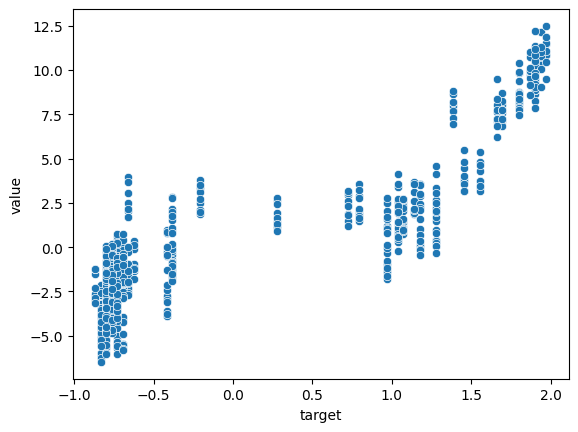

In [24]:
melted = results_df.melt(id_vars=['sequence', 'prediction', 'target', 'uncertainty', 'split'])
sns.scatterplot(melted.query('split == "test"'), x='target', y='value')

In [55]:
saved_dict = torch.load("test.pt")

/tmp/ipykernel_339285/2427733664.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_dict = torch.load("test.pt")


In [9]:

# Now you can analyze results by split
print("\nResults by split:")
for split in ['train', 'val', 'test']:
    split_df = results_df[results_df['split'] == split]
    correlation = spearmanr(split_df['prediction'], split_df['target']).correlation
    print(f"{split} split correlation: {correlation:.3f}")


Results by split:
train split correlation: 0.981
val split correlation: 0.946
test split correlation: 0.914


In [ ]:

print("DataFrame shape:", results_df.shape)
print("\nFirst few rows:")
print(results_df.head())

# Plot distribution of predictions for a few samples
plt.figure(figsize=(12, 6))
for i in range(min(5, len(results_df))):
    head_values = [results_df[f'head_{j}'][i] for j in range(num_heads)]
    plt.scatter([i] * num_heads, head_values, alpha=0.5, label=f'Sample {i}')
    plt.scatter(i, results_df['prediction'][i], color='red', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Prediction Value')
plt.title('Individual Head Predictions vs Ensemble Mean')
plt.legend()
plt.show()

# Plot correlation between heads
head_cols = [f'head_{i}' for i in range(num_heads)]
correlation_matrix = results_df[head_cols].corr()